In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
historical_data = yf.download('0005.hk',"2017-10-26","2021-11-08")
historical_data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data=pd.DataFrame()
data["Open"]=historical_data['Open']
data["High"]=historical_data['High']
data["Low"]=historical_data['Low']
data["Close"]=historical_data['Close']
data['H-L'] = historical_data['High'] - historical_data['Low']
data['O-C'] = historical_data['Close'] - historical_data['Open']
data["% Change"]=historical_data["Close"].pct_change()
data['7day MA'] = historical_data['Close'].shift(1).rolling(window = 5).mean()
data['14day MA'] = historical_data['Close'].shift(1).rolling(window = 10).mean()
data['21day MA'] = historical_data['Close'].shift(1).rolling(window = 20).mean()
data['Std_dev']= historical_data['Close'].shift(1).rolling(7).std()
data['RSI'] = talib.RSI(historical_data['Close'].values, timeperiod = 5)
data

,Open,High,Low,Close,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev,RSI
Date,,,,,,,,,,,,
2017-10-26,76.599998,77.099998,76.599998,76.900002,0.500000,0.300003,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-27,76.400002,77.449997,76.400002,77.099998,1.049995,0.699997,0.002601,NaN,NaN,NaN,NaN,NaN
2017-10-30,77.199997,78.050003,76.849998,76.849998,1.200005,-0.349998,-0.003243,NaN,NaN,NaN,NaN,NaN
2017-10-31,76.250000,76.599998,76.050003,76.199997,0.549995,-0.050003,-0.008458,NaN,NaN,NaN,NaN,NaN
2017-11-01,76.199997,76.800003,76.199997,76.650002,0.600006,0.450005,0.005906,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,46.549999,47.000000,46.349998,46.950001,0.650002,0.400002,-0.004242,47.24,46.790,44.8625,0.513044,57.750301
2021-11-02,47.450001,47.599998,46.950001,47.049999,0.649998,-0.400002,0.002130,47.29,46.865,45.1475,0.461364,60.451198
2021-11-03,46.799999,47.099998,46.500000,46.849998,0.599998,0.049999,-0.004251,47.20,46.955,45.4525,0.383902,52.121163


In [4]:
data.dropna(inplace=True)

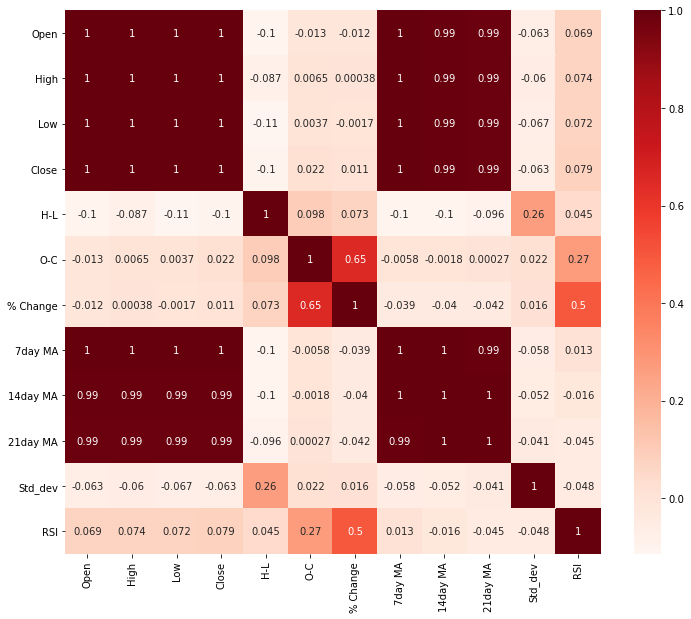

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
data.drop(["RSI","H-L","O-C","Std_dev"],1,inplace=True)

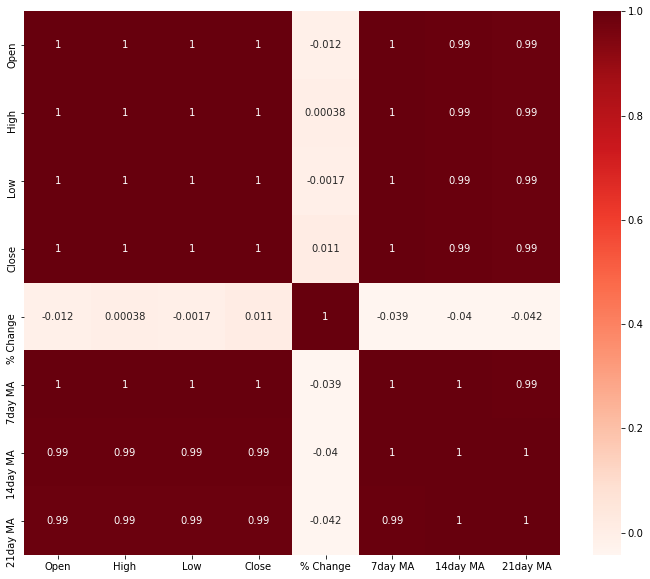

Open        0.999371
High        0.999708
Low         0.999704
Close       1.000000
7day MA     0.997027
14day MA    0.994719
21day MA    0.989632
Name: Close, dtype: float64

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(data.drop("Close",1))
y=data["Close"]

In [9]:
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        print(data[i:(i+lb)])
        Y.append(data_price[(i+lb)])
    return np.array(X),np.array(Y)

In [10]:
lb=5
X,y = processData(X,y.values,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

[[0.84648745 0.85004362 0.83578219 0.45232746 0.8256816  0.8250224
  0.84312185]
 [0.83174333 0.84045333 0.84010371 0.51834037 0.82849604 0.82556052
  0.84242872]
 [0.83694707 0.85004362 0.84010371 0.54280679 0.83218998 0.82618834
  0.84168939]
 [0.85082396 0.85004362 0.85220405 0.51825085 0.83817065 0.82825112
  0.84164318]
 [0.85255854 0.86312121 0.85911838 0.58066635 0.84291998 0.83147981
  0.84233631]]
[[0.83174333 0.84045333 0.84010371 0.51834037 0.82849604 0.82556052
  0.84242872]
 [0.83694707 0.85004362 0.84010371 0.54280679 0.83218998 0.82618834
  0.84168939]
 [0.85082396 0.85004362 0.85220405 0.51825085 0.83817065 0.82825112
  0.84164318]
 [0.85255854 0.86312121 0.85911838 0.58066635 0.84291998 0.83147981
  0.84233631]
 [0.85949699 0.86573676 0.86516861 0.50782508 0.84661393 0.83668161
  0.84358394]]
[[0.83694707 0.85004362 0.84010371 0.54280679 0.83218998 0.82618834
  0.84168939]
 [0.85082396 0.85004362 0.85220405 0.51825085 0.83817065 0.82825112
  0.84164318]
 [0.85255854 0.

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss='mean_squared_error',
  optimizer='Adam'
)

In [ ]:
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300


In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test.reshape(-1,1), marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    mbe = diff.mean()
    print('MBE = ', mbe)

MBE(y_test,y_pred)